# Part II: Training our Model

Now that we have a relatively tidy and balanced dataset of images, it is time to use them to train a classification model. We will be designing a Convolutional Neural Network to perform this task.

As CNNs require a lot of processing power to be trained, we will make use of the GPUs available through Google's colab service to complete this task. Therefore, there will be a couple of steps taken along the way to take care of that. In any case, our trained model can be stored and deployed in any machine, offline and without the need of GPUs.

## Loading Data

In [ ]:
# This step is to mount our Google drive on this notebook:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


With the Google Drive mounted, we can import our dataset to colab: 

In [1]:
TRAIN_DIR = '/path/to/training_wavs/'
TEST_DIR = '/path/to/testing_wavs/'

Now that the Google part is taken care of, we can go on with our standard approach on such tasks. First, we import the necessary libraries:

In [2]:
import numpy as np
import pandas as pd
import librosa as lb
import os
from os import walk
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt

### Extract Features from Audio Data:

First let's define a short function to extract the features from our audio files. In this case, the features are the MFCCs calculated via librosa, and they are stored as numpy arrays.

In [3]:
def getfeatures(path):
    '''Get MFCCs from the files in specified path'''
    sound, sr = lb.load(path)
    mfcc = lb.feature.mfcc(y=sound, sr=sr)
    return mfcc

Since the directories were arranged by label, we load the cough and non-cough audio separately. First we go through the cough .wav files to extract the MFCC features and stack them on an array *mfcc_0*.

In [ ]:
filepaths = []

for root, dirs, files in os.walk(TRAIN_DIR+'label_0/'):
  for name in files:
    filepaths.append(os.path.join(root,name))


mfcc_0 = []

for i, filepath in enumerate(filepaths):
  mfcc_0.append(getfeatures(filepath))
  if i % 10 == 0:
     print(i)

mfcc_0 = np.array(mfcc_0)

Let's make sure of the shape of this feature array. We can see that we have 647 samples, and each MFCC has a size (20, 44). The latter translates to 20 ceptral coefficients and 44 frequency bins.

In [7]:
mfcc_0.shape

(647, 20, 44)

Now we do the same to extract the features from the non-cough audio files.

In [ ]:
filepaths = []

for root, dirs, files in os.walk(TRAIN_DIR+'label_1/wav_1'):
  for name in files:
    filepaths.append(os.path.join(root,name))


mfcc_1 = []

for i, filepath in enumerate(filepaths):
  mfcc_1.append(getfeatures(filepath))
  if i % 10 == 0:
     print(i)

mfcc_1 = np.array(mfcc_1)

And of course we need to take care of the labels as well. Since we have loaded up the two classes separately, we can generate a label array simply by joining two arrays of zeros and ones with lengths corresponding to the number of samples in each class.

In [12]:
# Make labels for each class
y_0 = np.zeros(mfcc_0.shape[0])
y_1 = np.ones(mfcc_1.shape[0])
# Join up arrays
y = np.concatenate((y_0, y_1))
y = pd.Series(y, dtype=int)

### Format Input Data:

Although we have all the features we need to train the model loaded up, we need to bring them in a format that can be sent to a tensorflow neural network. To do that, we concatenate the arrays corresponding to the two classes, and we also expand towards an extra singular dimension.

In [14]:
# Join classes
X = np.concatenate((mfcc_0, mfcc_1))
# Expand dimension
X = np.expand_dims(X, axis=-1)
# Check shape
X.shape

(1290, 20, 44, 1)

So we have 1290 samples in total, each of size (20, 44, 1).

We also need to take care of the dimensionality for the labels as such:

In [13]:
y = pd.get_dummies(y).values

### Perform training and validation split:

Now that we have all the data and labels the way we need them, we can split it into training and validation sets with the classic sklearn method.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## Convolutional Neural Network

Now that our data is ready, it is time to design the convolutional neural network architecture, and set our training parameters. We will use three 2D convolutional layers, with additional batch normalization and a dropout layer at the end to improve upon the training process. Notice the input size is the same as we defined for our data above, 20x40x1, and the output size is 2, corresponding to two classes, activated via a softmax function.

In [16]:
mfcc_input=keras.layers.Input(shape=(20,44,1),name="mfccInput")
x=keras.layers.Conv2D(32,3,strides=(1,1),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,1),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(units = 64, activation = 'relu')(x)
x=keras.layers.Dropout(0.5)(x)

mfcc_output=keras.layers.Dense(2, activation='softmax')(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

Let's have a look at the summary of our model. 105,506 trainable parameters might seem a lot, but it's actually rather simple for a convolutional neural network.

In [17]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfccInput (InputLayer)       [(None, 20, 44, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 44, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 44, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 20, 44, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 22, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 22, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 22, 64)        25

Since we're feeling a bit fancy, let's get a full schematic of our CNN as well.

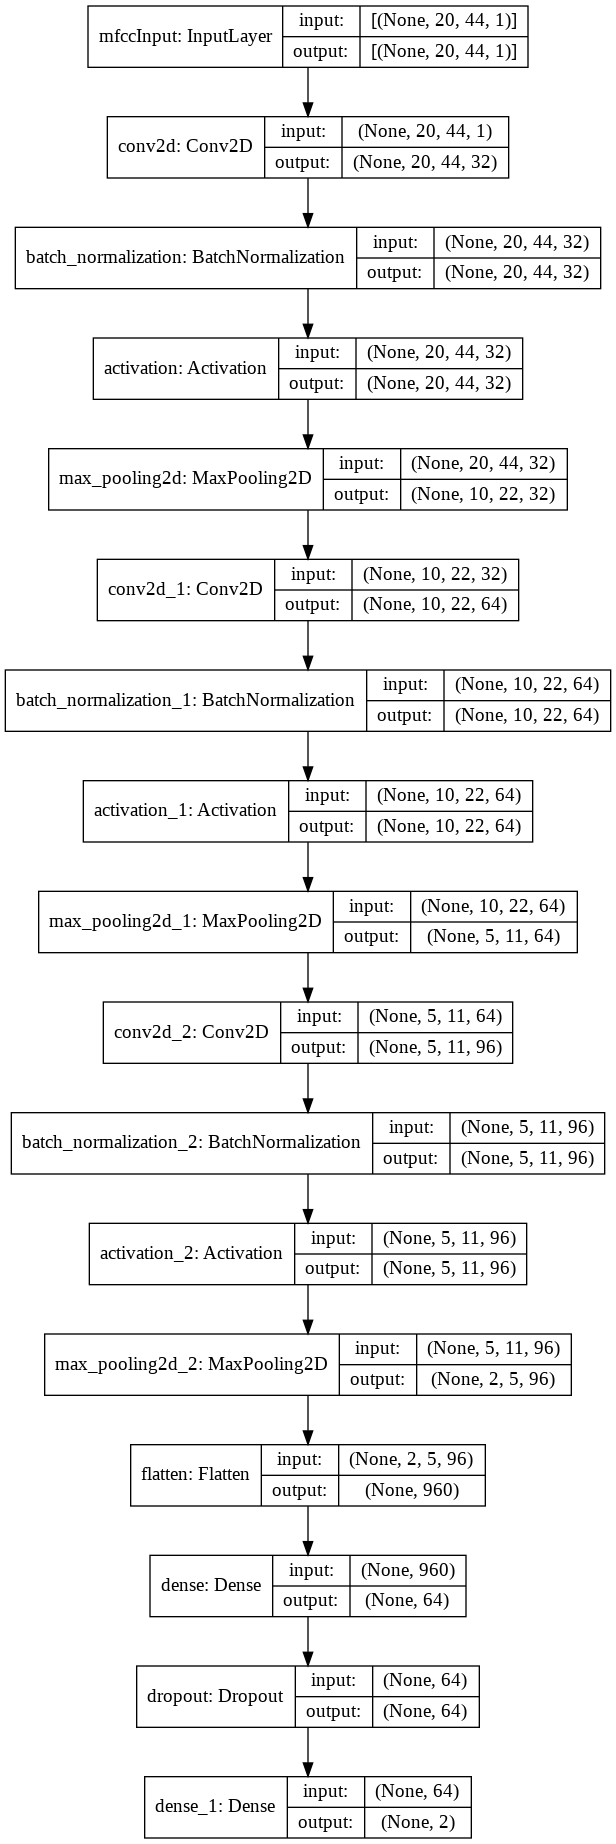

In [43]:
keras.utils.plot_model(mfcc_model, "mfcc_model.png", show_shapes=True)

Now that the design is finalized, we will compile the model using *binary crossentropy* as loss, *accuracy* as the metric, and use the optimizer *adam* with a starting learning rate of 0.001.

In [18]:
mfcc_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
K.set_value(mfcc_model.optimizer.learning_rate, 0.001)

### Train the model:

Before we commence the training process, it is useful to include a couple of callbacks so that the training becomes more efficient. We set an early stopping callback as well as a method to reduce the learning rate on plateaus of the loss function.

In [10]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

Now we can train the model:

In [19]:
history=mfcc_model.fit(
    X_train,
    y_train,
    validation_data=(X_val,y_val),
    epochs=20,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/20
33/33 [==============================] - 8s 16ms/step - loss: 0.4746 - accuracy: 0.8294 - val_loss: 0.2131 - val_accuracy: 0.9419
Epoch 2/20
33/33 [==============================] - 0s 7ms/step - loss: 0.1092 - accuracy: 0.9718 - val_loss: 0.1488 - val_accuracy: 0.9496
Epoch 3/20
33/33 [==============================] - 0s 6ms/step - loss: 0.0739 - accuracy: 0.9860 - val_loss: 0.1005 - val_accuracy: 0.9729
Epoch 4/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0669 - accuracy: 0.9750 - val_loss: 0.0816 - val_accuracy: 0.9690
Epoch 5/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.9858 - val_loss: 0.4777 - val_accuracy: 0.8798
Epoch 6/20
33/33 [==============================] - 0s 6ms/step - loss: 0.0798 - accuracy: 0.9721 - val_loss: 0.0554 - val_accuracy: 0.9767
Epoch 7/20
33/33 [==============================] - 0s 7ms/step - loss: 0.0207 - accuracy: 0.9951 - val_loss: 0.0336 - val_accuracy: 0.9845
Epoch 8/20
33/33 [=

Training seems to have gone well. We reached a 99.8 validation accuracy during the final epoch, even higher than the training accuracy. Also the early stopping callback was activated, and training stopped at the 13th epoch. We can visualize the process:

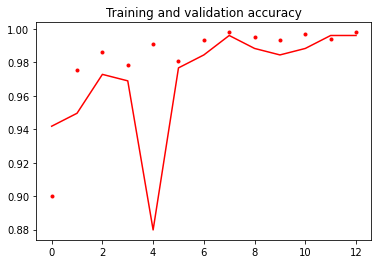

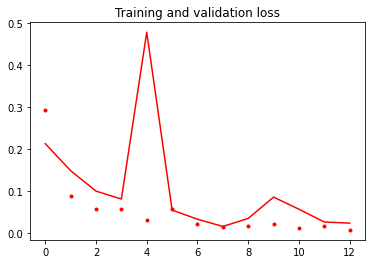

In [23]:
def plot_training(history):
    '''Plots training and validation accuracy and loss'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
  
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
  
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
  
plot_training(history)

We can notice an irregularity in the 4th epoch, where our validation performance was not nearly as good as in other epochs, but it seems to be an outlier. Other than this, we have a standard trend of increasing accuracy and decreasing loss.

### Evaluate the Model on Test Data:

Finally we will evaluate our model using a small selection of test data never seen by the model during training. To make sure that these samples are completely new to our model, the coughing audio samples here are generated from entirely different clips than those used in the making of the training datasets, so we are introducing some entirely new 'voices' to our model.

Let's load and format our data like we did with the training case:

In [32]:
filepaths = []

for root, dirs, files in os.walk(TEST_DIR):
  for name in files:
    filepaths.append(os.path.join(root,name))


mfcc_test = []

for i, filepath in enumerate(filepaths):
  mfcc_test.append(getfeatures(filepath))
  if i % 10 == 0:
     print(i)

mfcc_test = np.array(mfcc_test)

0
10
20
30
40
50


We can see that our testing selection consists of 52 samples.

In [41]:
X_test = np.expand_dims(mfcc_test, axis=-1)
X_test.shape

(52, 20, 44, 1)

Now load and format the labels.

In [39]:
y_test = np.load('y_test.npy')

y_test = pd.Series(y_test, dtype=int)

y_test = pd.get_dummies(y_test).values

y_test.shape

(52, 2)

And finally, time to evaluate the model on the test set using the evaluate function. We will print the loss and accuracy.

In [42]:
score, acc = mfcc_model.evaluate(X_test, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

2/2 [==============================] - 0s 30ms/step - loss: 0.4308 - accuracy: 0.9615
Test score: 0.4308384358882904
Test accuracy: 0.9615384340286255


96% Accuracy was achieved. This is a pretty encouraging performance from a relatively simple and lightweight CNN, especially when we consider the lack of consistency between our coughing audio clips.

We can now store this trained model for deployment.

In [21]:
mfcc_model.save('/content/drive/MyDrive/Colab_Models/model_CoughDetectionCNN.h5')